In [6]:
#you need to install pykeen beforehand, see https://pykeen.readthedocs.io/en/stable/installation.html 
import os
import numpy as np
import pandas as pd
import pykeen
import seaborn as sns

In [7]:
from rdflib import Graph, ConjunctiveGraph, Literal, BNode, Namespace, RDF, URIRef, RDFS

# Load the TTL file
d = Graph()
d.parse('Project/merged_individuals_updated_v2.ttl', format='turtle')

# Print serialized RDF
# print(d.serialize(format='turtle'))

<Graph identifier=N786cbe6cf66944ed9d78106f080f51e2 (<class 'rdflib.graph.Graph'>)>

## Link Prediction

In this approach, link prediction is applied to a knowledge graph (KG) to predict potential relationships between entities that are not explicitly present in the graph. The goal is to train a model that can learn the underlying patterns and relationships between nodes (entities) in the graph, based on the existing connections. Using a directed graph representation, RDF triples are converted into a directed graph, where nodes represent entities, and directed edges represent relationships. The model is trained on a dataset where both positive samples (existing relationships) and negative samples (non-existing relationships) are provided. Various graph-based features such as common neighbors, Jaccard coefficient, Adamic-Adar index, and preferential attachment are extracted to train a Random Forest classifier to predict missing links.

In [10]:
import rdflib
import networkx as nx
import random
import numpy as np
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Load RDF graph from TTL file
g = rdflib.Graph()
g.parse("Project/merged_individuals_updated_v2.ttl", format="ttl")

# Convert RDF graph to a directed NetworkX graph
G = nx.DiGraph()
for s, p, o in g:
    if isinstance(o, rdflib.URIRef):  # Ignore literals
        G.add_edge(str(s), str(o))

# Generate positive and negative samples
existing_edges = list(G.edges)

# For a directed graph, consider all possible ordered pairs (u, v) with u != v
all_possible_edges = [(u, v) for u in G.nodes for v in G.nodes if u != v]
non_existing_edges = [edge for edge in all_possible_edges if edge not in existing_edges]

# Balance the dataset by sampling negatives equal to the number of positive edges
negative_edges = random.sample(non_existing_edges, len(existing_edges))

In [11]:
# Feature extraction functions for a directed graph
def compute_features(graph, edge_list):
    features = []
    for u, v in edge_list:
        # Define neighbors as the union of predecessors and successors
        neighbors_u = set(graph.predecessors(u)).union(set(graph.successors(u)))
        neighbors_v = set(graph.predecessors(v)).union(set(graph.successors(v)))
        
        # Common neighbors and Jaccard coefficient
        common_neighbors = len(neighbors_u.intersection(neighbors_v))
        union_neighbors = neighbors_u.union(neighbors_v)
        jaccard_coeff = (common_neighbors / len(union_neighbors)) if union_neighbors else 0
        
        # Adamic-Adar index: sum over common neighbors of the inverse log of their degree
        adamic_adar = 0
        for n in neighbors_u.intersection(neighbors_v):
            # Compute degree as the union of in- and out-neighbors
            deg_n = len(set(graph.predecessors(n)).union(set(graph.successors(n))))
            if deg_n > 1:
                adamic_adar += 1 / np.log(deg_n)
        
        # Preferential attachment: product of degrees
        preferential_attachment = len(neighbors_u) * len(neighbors_v)
        
        features.append([common_neighbors, jaccard_coeff, adamic_adar, preferential_attachment])
    return np.array(features)

Accuracy: 0.8099688473520249
AUC-ROC: 0.8974423818762408
Total number of samples in the dataset: 6420


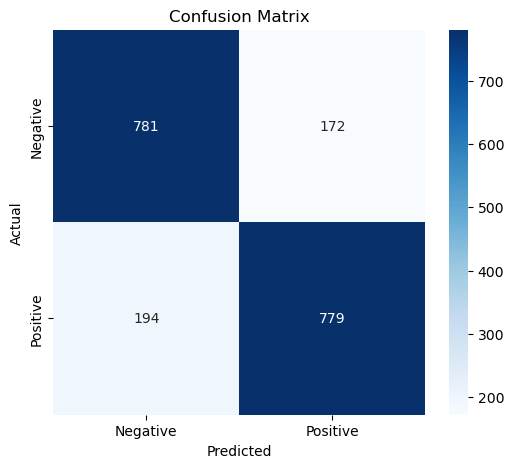

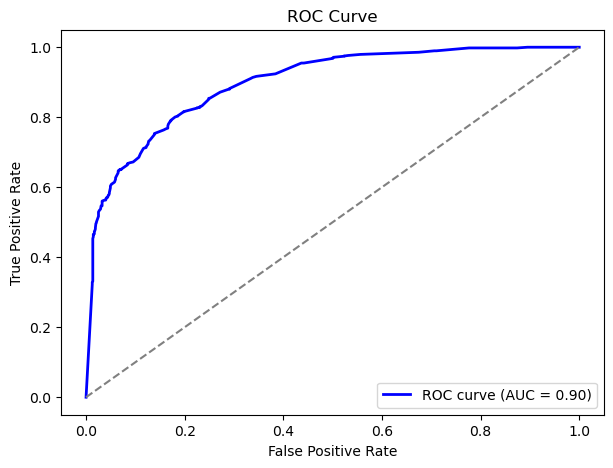

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Create dataset
X_pos = compute_features(G, existing_edges)
X_neg = compute_features(G, negative_edges)
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(len(X_pos)), np.zeros(len(X_neg))])  # 1 for existing, 0 for non-existing

# ---------------------------
# Train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))

# ---------------------------
# Visualization functions

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("Confusion_Matrix", dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig("ROC", dpi=300, bbox_inches='tight')
    plt.show()

# ---------------------------
# Run the visualization functions

# Print the total number of samples in the dataset (positive + negative samples)
total_samples = len(X)  # X contains both positive and negative samples
print(f"Total number of samples in the dataset: {total_samples}")
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_prob)